# Skin Color Estimation

In [1]:
import itertools
import json
import os
from pprint import pprint
import tempfile
from typing import List, Optional, Tuple

from tqdm import tqdm

import cv2 as cv
import numpy as np
from sklearn import metrics

from deepface import DeepFace

import matplotlib
from matplotlib import pyplot as plt

In [90]:
def cv_imshow(image: np.ndarray, ax=None) -> None:
    if ax:
        ax.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        ax.axis('off')
    else:
        plt.imshow(cv.cvtColor(image, cv.COLOR_BGR2RGB))
        plt.axis('off')

In [12]:
def quadrant_bboxes(img_size: Tuple[int, int]) -> List[List[int]]:
    width, height = [d // 2 for d in img_size]
    bboxes = [[x0, y0, x0+width, y0+width] for x0 in [0, width] for y0 in [0, height]]
    return bboxes

def crop_bbox(image: np.ndarray, bbox: np.array) -> np.ndarray:
    x0, y0, x1, y1 = bbox
    return image[y0:y1, x0:x1]

In [26]:
def df_bbox(region) -> List[int]:
    bbox = [
        region['x'],
        region['y'],
        region['x'] + region['w'],
        region['y'] + region['h']
    ]
    return bbox

def df_predictions(analysis: List[int], actions: Tuple[int]) -> dict:
    predictions = {action: analysis[action] for action in actions}
    predictions['bbox'] = df_bbox(analysis['region'])
    return predictions

In [20]:
df_backends = [
    'opencv',
    'ssd',
    'dlib',
    'mtcnn',
    'retinaface',
    'mediapipe'
]

df_actions = [
    'age',
    'gender',
    'race',
    'emotion'
]

def image_predictions(
    image: np.ndarray,
    actions: Tuple[int] = ('age', 'gender', 'race', 'emotion'),
    detector_backend: str = 'mtcnn',
    min_size: int = 20
) -> Optional[dict]:
    
    assert(all(action in df_actions for action in actions))
    assert(detector_backend in df_backends)
    
    predictions = None
    try:
        r = DeepFace.analyze(
            img_path=image,
            actions=actions,
            detector_backend=detector_backend,
            enforce_detection=True,
            prog_bar=False
        )
        if r['region']['w'] >= min_size and r['region']['h'] >= min_size:
            predictions = df_predictions(r, actions)
    except ValueError:
        pass
        
    return predictions

In [21]:
images_root = '../images/raw'

via_project_path = os.path.join(images_root, 'via_project_13Sep2022_19h41m.json')

In [22]:
with open(via_project_path, 'r') as f:
    via_project = json.load(f)
    
via_images = via_project['_via_image_id_list']
via_metadata = via_project['_via_img_metadata']

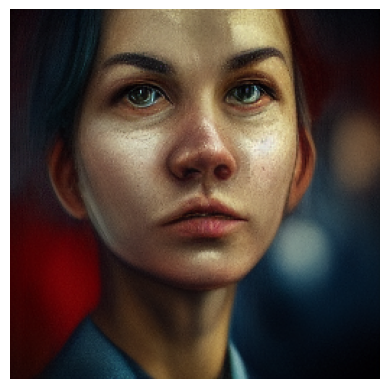

In [91]:
img_2x2 = cv.imread(img_path)
cv_imshow(img_2x2)

image = crop_bbox(img_2x2, quadrant_bboxes(img_2x2.shape[:2])[1])
cv_imshow(image)

In [68]:
def skin_color(
    image: np.ndarray,
    lower_quantile=0.5,
    upper_quantile=0.98
) -> Tuple[Tuple[int, int, int], np.ndarray]:
   
    img_l = cv.cvtColor(image, cv.COLOR_BGR2LAB)[:, :, 0]
    l_lower, l_upper = np.quantile(img_l, [lower_quantile, upper_quantile])
    
    mask = ((img_l >= l_lower) & (img_l <= l_upper))
    blue, green, red = image[mask].mean(axis=0)
    
    return (red, green, blue), mask

In [104]:
def color_show(color: Tuple[int, int, int], size=1, ax=None) -> None:
    color = tuple(c / 256 for c in color)
    rect = matplotlib.patches.Rectangle((0, 0), size, size, color=color)
    if ax is None:
        fig = plt.figure(figsize=(size, size))
        ax = fig.add_subplot(111)
    ax.add_patch(rect)
    ax.axis('off')

In [71]:
def image_equalize(image: np.ndarray, grid_size: int = 8) -> np.ndarray:
    img_lab = cv.cvtColor(image, cv.COLOR_BGR2LAB)
    img_l, img_a, img_b = cv.split(img_lab)
    
    clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(grid_size, grid_size))
    img_l = clahe.apply(img_l)
    
    img_lab = cv.merge((img_l, img_a, img_b))
    img_cl = cv.cvtColor(img_lab, cv.COLOR_LAB2BGR)
    return img_cl

1/1 [==============================] - 0s 18ms/step
{'age': 25,
 'bbox': [33, 0, 201, 191],
 'emotion': {'angry': 5.0065964460372925,
             'disgust': 0.003950842801714316,
             'fear': 1.5365757048130035,
             'happy': 30.47293722629547,
             'neutral': 5.732032284140587,
             'sad': 2.5591636076569557,
             'surprise': 54.688745737075806},
 'gender': {'Man': 24.55480247735977, 'Woman': 75.44519305229187},
 'race': {'asian': 0.31923078931868076,
          'black': 0.01849999971454963,
          'indian': 0.2657572505995631,
          'latino hispanic': 10.199444741010666,
          'middle eastern': 9.139369428157806,
          'white': 80.05769848823547}}


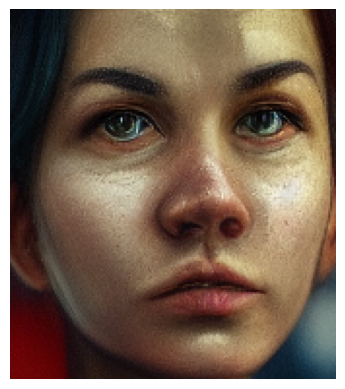

In [92]:
preds = image_predictions(image)
pprint(preds)
bbox = preds['bbox']
face = crop_bbox(image, bbox)
cv_imshow(face)

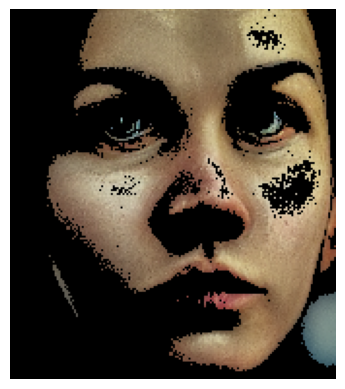

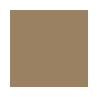

In [113]:
color, mask = skin_color(face)
cv_imshow(face*mask[:, :, np.newaxis])
color_show(color)

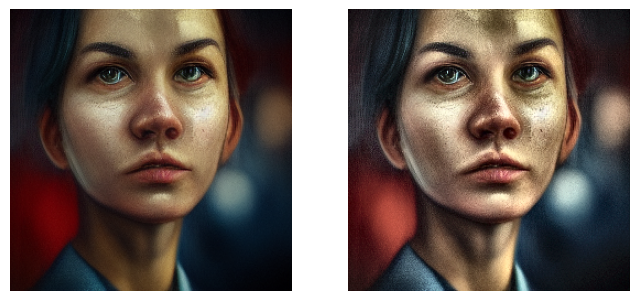

In [114]:
image_cl = image_equalize(image)

fig, ax = plt.subplots(1, 2, figsize=(8, 4))
cv_imshow(image, ax=ax[0])
cv_imshow(image_cl, ax=ax[1])

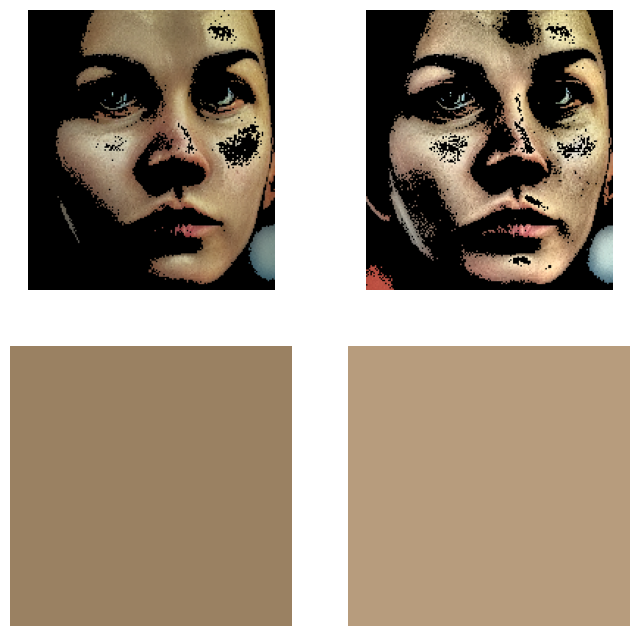

In [116]:
face_cl = crop_bbox(image_cl, bbox)

color_cl, mask_cl = skin_color(face_cl)

fig, ax = plt.subplots(2, 2, figsize=(8, 8))
cv_imshow(face*mask[:, :, np.newaxis], ax=ax[0, 0])
cv_imshow(face_cl*mask_cl[:, :, np.newaxis], ax=ax[0, 1])

color_show(color, ax=ax[1, 0])
color_show(color_cl, ax=ax[1, 1])